# L5 What Likelihood of Loss to Expect on a Stock Portfolio?

In [1]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
from mizani.formatters import percent_format
from plotnine import *
from datetime import datetime
from scipy.stats import norm

warnings.filterwarnings("ignore")

In [2]:
# Import the prewritten helper functions
from py_helper_functions import *

In [3]:
sp500 = (
    pd.read_csv("SP500_2006_16_data.csv")
    .replace("", np.nan)
    .replace("#N/A", np.nan)
    .dropna()
    .reset_index(drop=True)
)

Create percent return

In [4]:
sp500["pct_return"] = sp500["VALUE"].pct_change() * 100

Create date variables (we dont use these though)

In [5]:
sp500["DATE"] = pd.to_datetime(sp500["DATE"], format="%Y-%m-%d")
sp500["year"] = sp500["DATE"].dt.year
sp500["month"] = sp500["DATE"].dt.month
sp500["yearmonth"] = sp500["year"] * 100 + sp500["month"]

### Figure 5.1 Histogram of daily returns in the entire data

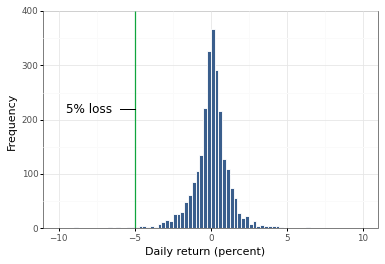

<ggplot: (8765546421905)>

In [6]:
(
    ggplot(sp500, aes("pct_return"))
    + geom_histogram(
        binwidth=0.25, color="white", fill=color[0], boundary=0, closed="left"
    )
    + geom_vline(xintercept=-5, size=0.7, color=color[1])
    + labs(x="Daily return (percent)", y="Frequency")
    + coord_cartesian(xlim=[-10, 10], ylim=[0, 400])
    + scale_y_continuous(expand=[0, 0])
    + geom_segment(aes(x=-6, y=220, xend=-5, yend=220))
    + annotate("text", x=-8, y=220, label="5% loss", size=12)
    + theme_bw()
)


### Figure 5.2 prep

 Create 10 000 samples, with 500 and 1000 observations in each sample, taken from sp500["pct_return"]

In every sample: for each observation, check if it is a loss of 5% or more. Then calculate the percentage of observations out of 500 or 1000 where the loss exceeds 5%. 

In [7]:
help(create_sample_frame)

Help on function create_sample_frame in module py_helper_functions:

create_sample_frame(vector: <built-in function array>, sample_size: int, n_samples=10000, with_replacement=False, seed=42) -> List[<built-in function array>]
    Function for a specified number of samples.
    Draws a specified number of observations from a vector, either with or without replacement.
    Returns the matrix of samples.
    
    Used in `ch05-stock-market-loss-generalize.ipynb`
    
       Parameters
    ----------
    vector : np.array
        Vector of observations.
    sample_size : int
        Sample size, you want to draw.
        Set it len(vector) for bootstrap sampling.
    n_samples : int, default=10000
        Number of samples.
    with_replacement : bool, default=False
        Whether to perform sampling with or without
        replacement. Set `True` for bootstrap sampling.
    seed : int,default=42
        Random seed for reproducibility.



In [8]:
nobs_1000 = np.mean(
    create_sample_frame(sp500["pct_return"], 1000, with_replacement=False) < -5,
    axis=1,
)
nobs_500 = np.mean(
    create_sample_frame(sp500["pct_return"], 500, with_replacement=False) < -5,
    axis=1,
)

In [9]:
nobs_df = pd.DataFrame({"nobs_500": nobs_500, "nobs_1000": nobs_1000}) * 100

In [10]:
error = (
    norm.ppf(0.975) * np.std(nobs_df["nobs_1000"]) / np.sqrt(len(nobs_df["nobs_1000"]))
)
left = np.mean(nobs_df["nobs_1000"]) - error
right = np.mean(nobs_df["nobs_1000"]) + error


### Figure 5.2

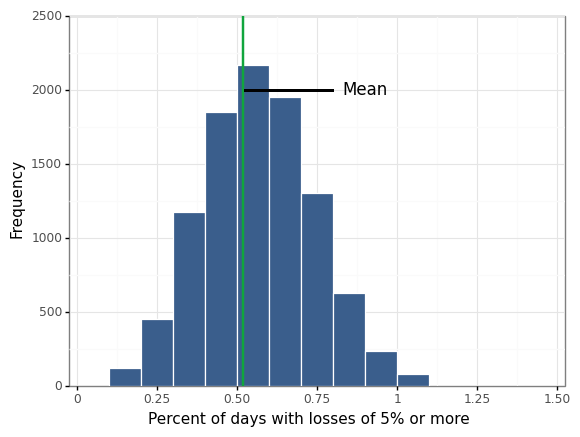

<ggplot: (8765546404269)>

In [11]:
(
    ggplot(nobs_df, aes("nobs_1000"))
    + geom_histogram(
        binwidth=0.1,
        color="white",
        fill=color[0],
        alpha=0.8,
        center=0.75,
        closed="left",
    )
    + labs(x="Percent of days with losses of 5% or more", y="Frequency")
    + geom_vline(aes(xintercept=nobs_df["nobs_1000"].mean()), color=color[1], size=1)
    + coord_cartesian(xlim=[0, 1.5], ylim=(0, 2500))
    + scale_x_continuous(expand=(0.01, 0.01), limits=(0, 1.5), breaks=seq(0, 1.5, 0.25))
    + scale_y_continuous(
        expand=(0.00, 0.00), limits=(0, 2500), breaks=seq(0, 2500, 500)
    )
    + geom_segment(aes(x=0.8, y=2000, xend=0.52, yend=2000))
    + annotate("text", x=0.9, y=2000, label="Mean", size=12)
    + theme_bw()
)

### Figure 5.3 

Not working with epanechnikov kernel

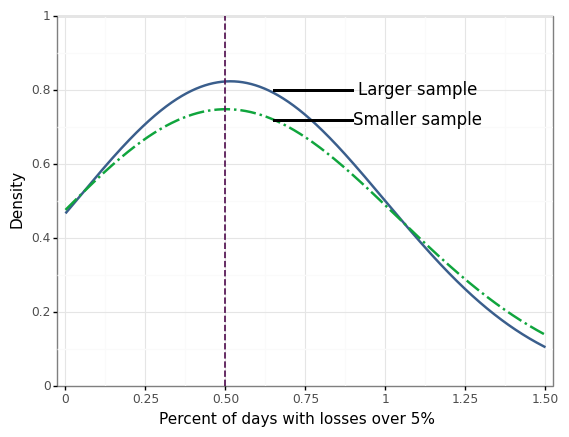

<ggplot: (8765508352181)>

In [12]:
(
    ggplot(nobs_df)
    + stat_density(aes(x="nobs_1000"), color=color[0], geom="line", bw=0.45, size=1)
    + stat_density(
        aes("nobs_500"),
        color=color[1],
        geom="line",
        bw=0.45,
        linetype="dashdot",
        size=1,
    )
    + labs(x="Percent of days with losses over 5%", y="Density")
    + geom_vline(xintercept=0.5, color=color[2], size=0.7, linetype="dashed")
    + geom_segment(aes(x=0.9, y=0.8, xend=0.65, yend=0.8), size=0.5)
    + annotate("text", x=1.1, y=0.8, label="Larger sample", size=12)
    + geom_segment(aes(x=0.9, y=0.72, xend=0.65, yend=0.72), size=0.5)
    + annotate("text", x=1.1, y=0.72, label="Smaller sample", size=12)
    + scale_x_continuous(expand=(0.01, 0.01), limits=(0, 1.5), breaks=seq(0, 1.5, 0.25))
    + scale_y_continuous(expand=(0.00, 0.00), limits=(0, 1), breaks=seq(0, 1, 0.2))
    + theme_bw()
    + theme(
        legend_position="none",
    )
)

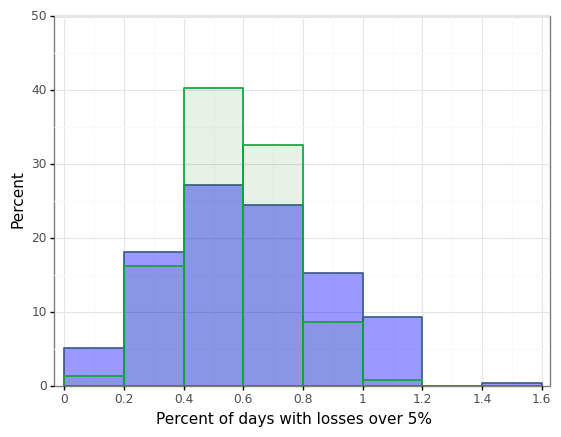

<ggplot: (8765508469365)>

In [13]:
(
    ggplot(nobs_df)
    + geom_histogram(
        aes(x="nobs_500", y="stat(count)/sum(stat(count))*100"),
        color=color[0],
        fill="blue",
        binwidth=0.2,
        center=0.5,
        size=0.7,
        alpha=0.4,
        closed="left",
    )
    + geom_histogram(
        aes(x="nobs_1000", y="stat(count)/sum(stat(count))*100"),
        color=color[1],
        fill="green",
        binwidth=0.2,
        center=0.5,
        alpha=0.1,
        size=0.7,
        closed="left",
    )
    + ylab("Percent")
    + xlab("Percent of days with losses over 5%")
    + scale_x_continuous(
        expand=(0.01, 0.01), limits=(-0.01, 1.6), breaks=seq(0, 1.6, 0.2)
    )
    + scale_y_continuous(expand=(0.00, 0.00), limits=(0, 50))
    + scale_color_manual(
        labels=("N = 1000", "N = 500"), name="", values=(color[1], color[0])
    )
    + scale_alpha_identity()
    + scale_fill_identity()
    + theme_bw()
    + theme(
        legend_direction="horizontal",
    )
)


Create bootstrap samples

In [14]:
bootstrap_samples = create_sample_frame(
    sp500["pct_return"], len(sp500["pct_return"]), with_replacement=True
)

Calculate percent of days wit losses over  thresholds from -1 to 10

In [15]:
bootstrap_loss_results = pd.DataFrame(
    [
        np.mean(bootstrap_samples < -1 * pct_loss, axis=1) * 100
        for pct_loss in range(1, 11)
    ],
    index=[f"loss{i}" for i in range(1, 11)],
).T

Plot percent of days with losses over -5%

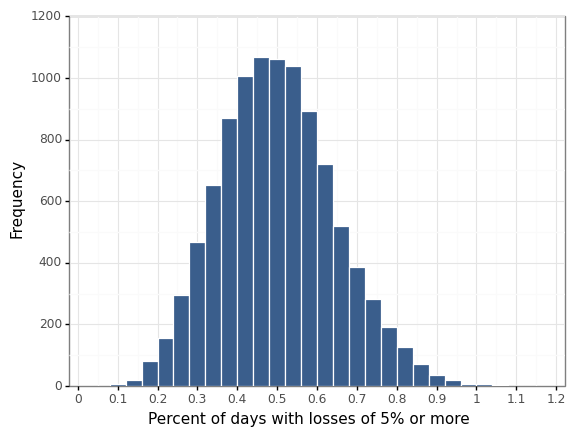

<ggplot: (8765508346321)>

In [16]:
(
    ggplot(bootstrap_loss_results, aes("loss5"))
    + geom_histogram(
        fill=color[0], color="white", binwidth=0.04, boundary=0, closed="left"
    )
    + scale_y_continuous(expand=(0, 0), limits=(0, 1200), breaks=seq(0, 1200, 200))
    + scale_x_continuous(expand=(0.01, 0.01), limits=(0, 1.2), breaks=seq(0, 1.2, 0.1))
    + labs(x="Percent of days with losses of 5% or more", y="Frequency")
    + theme_bw()
)
